# Notebook for alignment analysis

Imports

In [1]:
import time
import os
import importlib

from pprint import pprint
from collections import defaultdict
from pathlib import Path
from more_itertools import grouper
from itertools import islice, chain, zip_longest, repeat

import numpy as np
import pandas as pd

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib.axes as ax
import seaborn as sns

import scipy
from scipy import io
from scipy.signal import convolve
from scipy.sparse import coo_matrix, csr_matrix
from scipy.stats import pearsonr
from scipy.cluster.hierarchy import cut_tree

from statsmodels.stats import multitest

from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder

import pyBigWig
import pysam
import re

from Modules import utils, plot_utils

Useful global variables

In [129]:
importlib.reload(utils)
importlib.reload(plot_utils)
data_dir = '../shared_folder'
writing_dir = '../shared_folder'
# writing_dir='../'
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

Name of chromosomes in GRCh38 and T2T-CHM13v2.0
Header for BigWig files, with chromosome lengths

In [3]:
hg38_chr_ids = {
    1: 'NC_000001.11',
    2: 'NC_000002.12',
    3: 'NC_000003.12',
    4: 'NC_000004.12',
    5: 'NC_000005.10',
    6: 'NC_000006.12',
    7: 'NC_000007.14',
    8: 'NC_000008.11',
    9: 'NC_000009.12',
    10: 'NC_000010.11',
    11: 'NC_000011.10',
    12: 'NC_000012.12',
    13: 'NC_000013.11',
    14: 'NC_000014.9',
    15: 'NC_000015.10',
    16: 'NC_000016.10',
    17: 'NC_000017.11',
    18: 'NC_000018.10',
    19: 'NC_000019.10',
    20: 'NC_000020.11',
    21: 'NC_000021.9',
    22: 'NC_000022.11',
    'X': 'NC_000023.11',
    'Y': 'NC_000024.10',}
T2T_chr_ids = {
    1: 'NC_060925.1',
    2: 'NC_060926.1',
    3: 'NC_060927.1',
    4: 'NC_060928.1',
    5: 'NC_060929.1',
    6: 'NC_060930.1',
    7: 'NC_060931.1',
    8: 'NC_060932.1',
    9: 'NC_060933.1',
    10: 'NC_060934.1',
    11: 'NC_060935.1',
    12: 'NC_060936.1',
    13: 'NC_060937.1',
    14: 'NC_060938.1',
    15: 'NC_060939.1',
    16: 'NC_060940.1',
    17: 'NC_060941.1',
    18: 'NC_060942.1',
    19: 'NC_060943.1',
    20: 'NC_060944.1',
    21: 'NC_060945.1',
    22: 'NC_060946.1',
    'X': 'NC_060947.1',
    'Y': 'NC_060948.1',}
GRCh38_header = [
    ("chr1", 248956422),
    ("chr2", 242193529),
    ("chr3", 198295559),
    ("chr4", 190214555),
    ("chr5", 181538259),
    ("chr6", 170805979),
    ("chr7", 159345973),
    ("chr8", 145138636),
    ("chr9", 138394717),
    ("chr10", 133797422),
    ("chr11", 135086622),
    ("chr12", 133275309),
    ("chr13", 114364328),
    ("chr14", 107043718),
    ("chr15", 101991189),
    ("chr16", 90338345),
    ("chr17", 83257441),
    ("chr18", 80373285),
    ("chr19", 58617616),
    ("chr20", 64444167),
    ("chr21", 46709983),
    ("chr22", 50818468),
    ("chrX", 156040895),
    ("chrY", 57227415),]
GRCh38_lengths = dict(GRCh38_header)
T2T_header = [
    ("chr1", 248387328),
    ("chr2", 242696752),
    ("chr3", 201105948),
    ("chr4", 193574945),
    ("chr5", 182045439),
    ("chr6", 172126628),
    ("chr7", 160567428),
    ("chr8", 146259331),
    ("chr9", 150617247),
    ("chr10", 134758134),
    ("chr11", 135127769),
    ("chr12", 133324548),
    ("chr13", 113566686),
    ("chr14", 101161492),
    ("chr15", 99753195),
    ("chr16", 96330374),
    ("chr17", 84276897),
    ("chr18", 80542538),
    ("chr19", 61707364),
    ("chr20", 66210255),
    ("chr21", 45090682),
    ("chr22", 51324926),
    ("chrX", 154259566),
    ("chrY", 62460029),]
T2T_lengths = dict(T2T_header)
# {"NC_060925.1":"1", "NC_060926.1":"2", "NC_060927.1":"3", "NC_060928.1":"4", "NC_060929.1":"5", "NC_060930.1":"6", "NC_060931.1":"7", "NC_060932.1":"8", "NC_060933.1":"9", "NC_060934.1":"10", "NC_060935.1":"11", "NC_060936.1":"12", "NC_060937.1":"13", "NC_060938.1":"14", "NC_060939.1":"15", "NC_060940.1":"16", "NC_060941.1":"17", "NC_060942.1":"18", "NC_060943.1":"19", "NC_060944.1":"20", "NC_060945.1":"21", "NC_060946.1":"22", "NC_060947.1":"X", "NC_060948.1":"Y"}

Parse sam files and save in npz format (deprecated)

In [ ]:
data = 'Judith-H3K27me3'
# ip_coord = utils.parse_sam(Path(data_dir, data, 'raw_data', 'IP', D1145C41_trimmed_paired.sam'))
# ctrl_coord = utils.parse_sam(Path(data_dir, data, 'raw_data, 'Control, 'D1145C46_trimmed_paired.sam'))

# if not Path(data_dir, data, 'results', f'{data}_IP_coord_all_chr.npz').is_file():
#     np.savez_compressed(Path(data_dir, data, 'results', f'{data}_IP_coord_all_chr'),
#                         **ip_coord)
# if not Path(data_dir, data, 'results', f'{data}_Control_coord_all_chr.npz').is_file():
#     np.savez_compressed(Path(data_dir, data, 'results', f'{data}_Control_coord_all_chr'),
#                         **ctrl_coord)

54717931/105167322 paired reads rejected


Parse bam files and save in npz format

In [106]:
data = 'Judith-H3K9me3'
genome = 'T2T-CHM13v2.0'
ip_coord = utils.parse_bam(Path(data_dir, data, 'results', 'alignments', genome, 'D1145C43_trimmed_paired_T2T.sorted.bam'))
ctrl_coord = utils.parse_bam(Path(data_dir, data, 'results', 'alignments', genome, 'D1145C44_trimmed_paired_T2T.sorted.bam'))
if not Path(data_dir, data, 'results', 'alignments', genome, f'{data}_{genome}_IP_coord_all_chr.npz').is_file():
    np.savez_compressed(Path(data_dir, data, 'results', 'alignments', genome, f'{data}_{genome}_IP_coord_all_chr'),
                        **ip_coord)
if not Path(data_dir, data, 'results', 'alignments', genome, f'{data}_{genome}_Control_coord_all_chr.npz').is_file():
    np.savez_compressed(Path(data_dir, data, 'results', 'alignments', genome, f'{data}_{genome}_Control_coord_all_chr'),
                        **ctrl_coord)


57440123/112349018 paired reads rejected
46895829/91894522 paired reads rejected


Full genome analysis

In [13]:
data = 'Judith-H3K4me3'
genome = 'T2T-CHM13v2.0'
threshold = 500
bins = 1000

if genome == 'T2T-CHM13v2.0':
    lengths = T2T_lengths
    chr_ids = T2T_chr_ids
elif genome == 'GRCh38':
    lengths = GRCh38_lengths
    chr_ids = hg38_chr_ids
log_file = Path(data_dir, data, 'results', 'alignments', genome, 'alignment_analysis_log.txt')
log_file = utils.safe_filename(log_file)
with open(log_file, 'w') as f:
    f.write(f'data: {data}\n'
            f'genome: {genome}\n'
            f'length threshold: {threshold}\n'
            f'bins: {bins}\n\n')
ip_lengths = []
ctrl_lengths = []
for chr_id in chr_ids.keys():
    print(f"processing chr{chr_id}...")
    # Load chromosome
    with np.load(Path(data_dir, data, 'results', 'alignments', genome, f'{data}_{genome}_IP_coord_all_chr.npz')) as f:
        ip_coord_chr = f[chr_ids[chr_id]]
    with np.load(Path(data_dir, data, 'results', 'alignments', genome, f'{data}_{genome}_Control_coord_all_chr.npz')) as f:
        ctrl_coord_chr = f[chr_ids[chr_id]]
    # Filter out fragments too long
    ip_lengths_chr = np.diff(ip_coord_chr, axis=1).ravel()
    ctrl_lengths_chr = np.diff(ctrl_coord_chr, axis=1).ravel()
    ip_lengths.append(ip_lengths_chr)
    ctrl_lengths.append(ctrl_lengths_chr)
    ip_coord_chr = ip_coord_chr[ip_lengths_chr <= threshold, :]
    ctrl_coord_chr = ctrl_coord_chr[ctrl_lengths_chr <= threshold, :]
    # Get binned middle alignment
    ip_binned_signal_chr = utils.binned_alignment_signal_from_coord(ip_coord_chr, bins=bins, length=lengths[f'chr{chr_id}'])
    ctrl_binned_signal_chr = utils.binned_alignment_signal_from_coord(ctrl_coord_chr, bins=bins, length=lengths[f'chr{chr_id}'])
    # Get processed signals
    log_ratio_chr = np.log10(ip_binned_signal_chr / ctrl_binned_signal_chr)
    KL_chr = ip_binned_signal_chr * np.log10(ip_binned_signal_chr / ctrl_binned_signal_chr)
    p_binom = len(ip_coord_chr) / (len(ip_coord_chr) + len(ctrl_coord_chr))
    n_binom = ip_binned_signal_chr + ctrl_binned_signal_chr
    p_vals = 1 - scipy.stats.binom.cdf(ip_binned_signal_chr - 1, n_binom, p_binom)
    # Correct p_values
    reject, q_vals, _, _ = multitest.multipletests(p_vals, method='fdr_bh')
    # Write log info
    with open(log_file, 'a') as f:
        f.write(f'Processing chr{chr_id}...\n'
                f'{np.sum(ip_lengths_chr >= threshold)} fragments longer than {threshold}bp in IP\n'
                f'{np.sum(ctrl_lengths_chr >= threshold)} fragments longer than {threshold}bp in Control\n'
                f'{np.sum(reject)}/{len(reject)} rejected\n')
    # Make dataframe and save
    df = pd.DataFrame({'pos': np.arange(0, len(ip_binned_signal_chr)*bins, bins),
                       'ip_binned_signal': ip_binned_signal_chr,
                       'ctrl_binned_signal': ctrl_binned_signal_chr,
                       'log_ratio': log_ratio_chr,
                       'KL': KL_chr,
                       'binom_p_value': p_vals,
                       'binom_q_value': q_vals})
    csv_name = Path(data_dir, data, 'results', 'alignments', genome, f'{data}_{genome}_chr{chr_id}_thres_{threshold}_binned_{bins}.csv')
    csv_name = utils.safe_filename(csv_name)
    df.to_csv(csv_name)
ip_lengths = np.concatenate(tuple(ip_lengths))
ctrl_lengths = np.concatenate(tuple(ctrl_lengths))

processing chr1...


/tmp/ipykernel_270277/2895481266.py:39: RuntimeWarning: divide by zero encountered in true_divide
  log_ratio_chr = np.log10(ip_binned_signal_chr / ctrl_binned_signal_chr)
/tmp/ipykernel_270277/2895481266.py:39: RuntimeWarning: invalid value encountered in true_divide
  log_ratio_chr = np.log10(ip_binned_signal_chr / ctrl_binned_signal_chr)
/tmp/ipykernel_270277/2895481266.py:39: RuntimeWarning: divide by zero encountered in log10
  log_ratio_chr = np.log10(ip_binned_signal_chr / ctrl_binned_signal_chr)
/tmp/ipykernel_270277/2895481266.py:40: RuntimeWarning: divide by zero encountered in true_divide
  KL_chr = ip_binned_signal_chr * np.log10(ip_binned_signal_chr / ctrl_binned_signal_chr)
/tmp/ipykernel_270277/2895481266.py:40: RuntimeWarning: invalid value encountered in true_divide
  KL_chr = ip_binned_signal_chr * np.log10(ip_binned_signal_chr / ctrl_binned_signal_chr)
/tmp/ipykernel_270277/2895481266.py:40: RuntimeWarning: divide by zero encountered in log10
  KL_chr = ip_binned_sig

processing chr2...
processing chr3...
processing chr4...
processing chr5...
processing chr6...
processing chr7...
processing chr8...
processing chr9...
processing chr10...
processing chr11...
processing chr12...
processing chr13...
processing chr14...
processing chr15...
processing chr16...
processing chr17...
processing chr18...
processing chr19...
processing chr20...
processing chr21...
processing chr22...
processing chrX...
processing chrY...


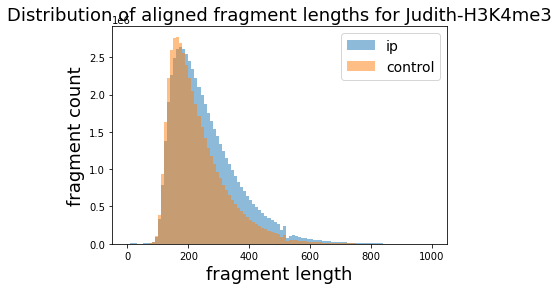

In [14]:
plt.hist(ip_lengths, bins=100, range=(0, 1000), label='ip', alpha=0.5)
plt.hist(ctrl_lengths, bins=100, range=(0, 1000), label='control', alpha=0.5)
plt.legend(fontsize=14)
plt.title(f'Distribution of aligned fragment lengths for {data}', fontsize=18)
plt.xlabel('fragment length', fontsize=18)
plt.ylabel('fragment count', fontsize=18)
fig_name = Path(data_dir, data, 'results', f'{data}_fragment_length_distribution.png')
fig_name = utils.safe_filename(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

Merging to a full genome

In [130]:
def merging_full_genome(data, genome, threshold, bins, verbose=True):
    if genome == 'T2T-CHM13v2.0':
        lengths = T2T_lengths
        chr_ids = T2T_chr_ids
    elif genome == 'GRCh38':
        lengths = GRCh38_lengths
        chr_ids = hg38_chr_ids
    # merging chromosomes
    binned_lengths = np.array([x // bins + 1 for x in lengths.values()])
    seperators = np.cumsum(binned_lengths)
    total_length = seperators[-1]
    for i, chr_id in enumerate(chr_ids.keys()):
        df = pd.read_csv(Path(data_dir, data, 'results', 'alignments', genome, f'{data}_{genome}_chr{chr_id}_thres_{threshold}_binned_{bins}.csv'),
                         index_col=0)
        if i == 0:
            full_genome = pd.DataFrame(
                np.zeros((total_length, len(df.columns))),
                columns=df.columns)
        full_genome.iloc[seperators[i]-len(df):seperators[i], :] = df
    # computing p_value and q_value
    sums = full_genome.sum(axis=0)
    p_binom = sums["ip_binned_signal"] / (sums["ip_binned_signal"] + sums["ctrl_binned_signal"])
    n_binom = full_genome["ip_binned_signal"] + full_genome["ctrl_binned_signal"]
    full_genome['binom_p_value_complete'] = utils.clip_to_nonzero_min(1 - scipy.stats.binom.cdf(full_genome["ip_binned_signal"] - 1, n_binom, p_binom))
    # full_genome['binom_p_value_complete'] = utils.clip_to_min(full_genome['binom_p_value_complete'])
    reject, q_value, *_ = multitest.multipletests(full_genome["binom_p_value_complete"], method='fdr_bh')
    full_genome['binom_q_value_complete'] = q_value
    full_genome['-log(qvalue_complete)'] = -np.log10(q_value)
    full_genome['-log(pvalue_complete)'] = -np.log10(full_genome["binom_p_value_complete"])
    full_genome['significantly_enriched'] = reject
    if verbose:
        print(f'{np.sum(reject)}/{len(reject)} significantly enriched bins in {data}')
        print(f'{np.sum(full_genome["binom_q_value"]<0.05)}/{len(reject)} significantly enriched bins in {data} when chromosome local')
    return full_genome, seperators

In [131]:
genome = 'T2T-CHM13v2.0'
threshold = 500
bins = 1000

data = 'Judith-H3K4me3'
full_genome_H3K4me3, seperators = merging_full_genome(data, genome, threshold, bins)
data = 'Judith-H3K9me3'
full_genome_H3K9me3, _ = merging_full_genome(data, genome, threshold, bins)

30037/3117287 significantly enriched bins in Judith-H3K4me3
29480/3117287 significantly enriched bins in Judith-H3K4me3 when chromosome local
2757/3117287 significantly enriched bins in Judith-H3K9me3
2121/3117287 significantly enriched bins in Judith-H3K9me3 when chromosome local


Computing p_value and q_value on full genome

In [132]:
print(np.sum(full_genome_H3K9me3['ip_binned_signal']), ' in H3K9me3')
print(np.sum(full_genome_H3K4me3['ip_binned_signal']), 'in H3K4me3')
print(np.sum(full_genome_H3K9me3['ctrl_binned_signal']), 'in INPUT-H3K9me3')
print(np.sum(full_genome_H3K4me3['ctrl_binned_signal']), 'in INPUT-H3K4me3')

53399358.0  in H3K9me3
52844132.0 in H3K4me3
43781228.0 in INPUT-H3K9me3
44410565.0 in INPUT-H3K4me3


In [133]:
full_genome_H3K9me3

,pos,ip_binned_signal,ctrl_binned_signal,log_ratio,KL,binom_p_value,binom_q_value,binom_p_value_complete,binom_q_value_complete,-log(qvalue_complete),-log(pvalue_complete),significantly_enriched
0,0.0,20.0,14.0,0.154902,3.098039,0.356285,1.000000,0.391354,1.000000,-0.000000,0.407430,False
1,1000.0,23.0,15.0,0.185637,4.269641,0.267338,1.000000,0.300416,1.000000,-0.000000,0.522278,False
2,2000.0,2.0,1.0,0.301030,0.602060,0.562286,1.000000,0.573986,1.000000,-0.000000,0.241098,False
3,3000.0,19.0,16.0,0.074634,1.418039,0.563249,1.000000,0.600031,1.000000,-0.000000,0.221826,False
4,4000.0,25.0,15.0,0.221849,5.546219,0.184486,0.975306,0.212312,0.989413,0.004622,0.673025,False
...,...,...,...,...,...,...,...,...,...,...,...,...
3117282,62456000.0,9.0,6.0,0.176091,1.584821,0.577212,1.000000,0.450551,1.000000,-0.000000,0.346256,False
3117283,62457000.0,6.0,4.0,0.176091,1.056548,0.606707,1.000000,0.503068,1.000000,-0.000000,0.298374,False
3117284,62458000.0,6.0,11.0,-0.263241,-1.579449,0.986611,1.000000,0.969607,1.000000,-0.000000,0.013404,False
3117285,62459000.0,14.0,3.0,0.669007,9.366095,0.038708,1.000000,0.018261,0.468298,0.329478,1.738478,False


In [259]:
def fdr_bh(p):
    q = np.copy(p)
    # sort
    order = np.argsort(q)
    q = q[order]
    # compute p_value correction
    q = np.minimum(q*len(q)/np.arange(1, len(q)+1), 1)
    # preserve order by taking min of upper values
    q[::-1] = np.minimum.accumulate(q[::-1])
    # unsort before output
    return q[np.argsort(order)]

my_q_value_H3K9me3 = fdr_bh(full_genome_H3K9me3['binom_p_value_complete'])
my_q_value_H3K4me3 = fdr_bh(full_genome_H3K4me3['binom_p_value_complete'])

assert np.allclose(my_q_value_H3K9me3, full_genome_H3K9me3['binom_q_value_complete'])
assert np.allclose(my_q_value_H3K4me3, full_genome_H3K4me3['binom_q_value_complete'])

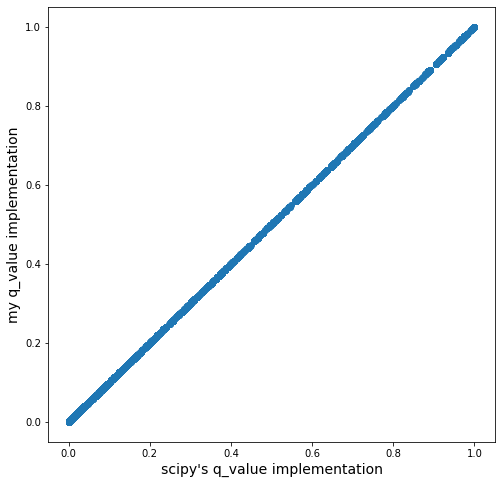

In [248]:
plt.figure(figsize=(8, 8))
plt.scatter(full_genome_H3K4me3['binom_q_value_complete'], my_q_value_H3K4me3)
plt.xlabel("scipy's q_value implementation", fontsize=14)
plt.ylabel("my q_value implementation", fontsize=14)
# plt.xscale('log')
# plt.yscale('log')
plt.show()
plt.close()

/home/alex/anaconda3/envs/tf2.5/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


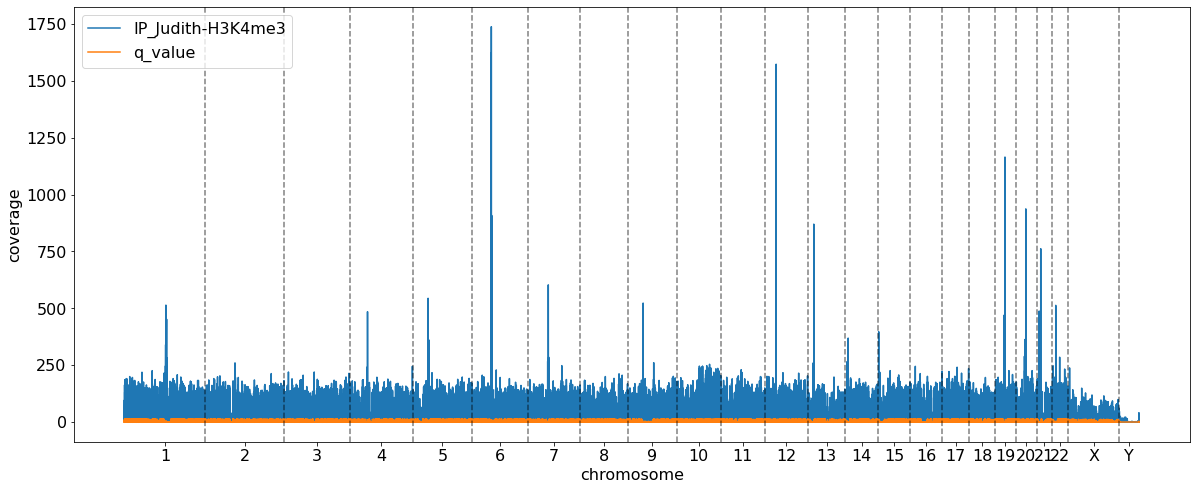

In [41]:
ax = full_genome_H3K4me3.plot(y=['ip_binned_signal', '-log(qvalue_complete)'], figsize=(20, 8), label=[f'IP_{data}', 'q_value'], fontsize=16)
for sep in seperators[:-1]:
    plt.axvline(x=sep, color='black', linestyle='--', alpha=0.5)
ax.set_xticks(utils.moving_average(np.insert(seperators, 0, 0)))
ax.set_xticklabels(chr_ids.keys())
plt.legend(fontsize=16)
plt.xlabel('chromosome', fontsize=16)
plt.ylabel('coverage', fontsize=16)
plt.show()
plt.close()

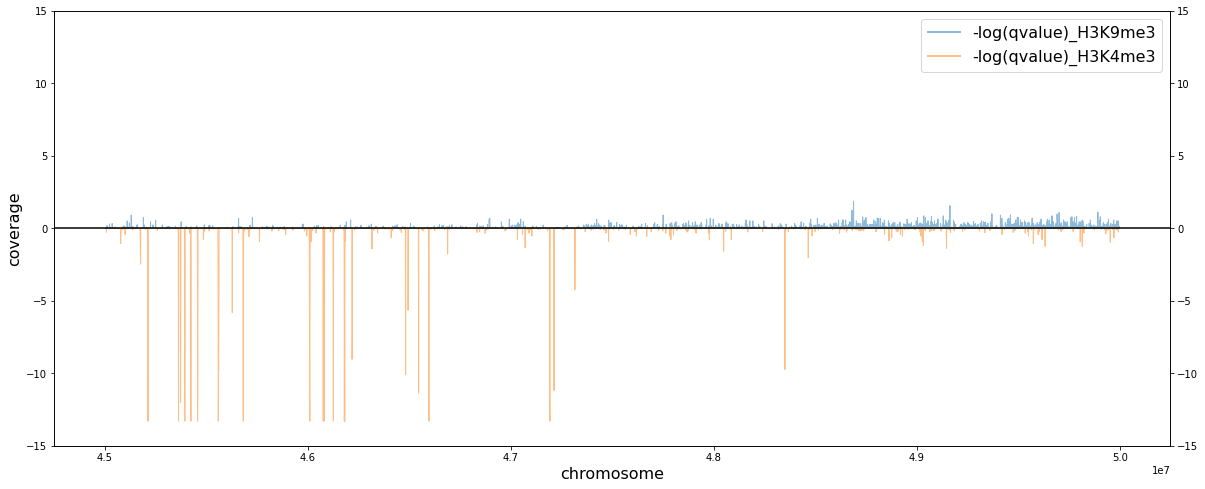

In [158]:
start = 45_000_000
end = 50_000_000 # seperators[0]*bins
values_list = [full_genome_H3K9me3['-log(qvalue_complete)'], -full_genome_H3K4me3['-log(qvalue_complete)']]
label_list = ['-log(qvalue)_H3K9me3', '-log(qvalue)_H3K4me3']

plt.figure(figsize=(20, 8))
axes = plot_utils.compare_binned_plots(values_list, label_list, start, end, bins, alpha=0.5, linewidth=1)
lim = 15
axes[0].set_ylim(bottom=-lim, top=lim)
axes[1].set_ylim(bottom=-lim, top=lim)
# for sep in seperators[:-1]:
#     plt.axvline(x=sep*bins, color='black', linestyle='--', alpha=0.5)
# axes[0].set_xticks(utils.moving_average(np.insert(seperators*bins, 0, 0)))
# axes[0].set_xticklabels(list(chr_ids.keys()), fontsize=16)
axes[0].set_xlabel('chromosome', fontsize=16)
axes[0].set_ylabel('coverage', fontsize=16)
plt.axhline(y=0, color='black')
plt.show()
plt.close()

Autocorrelation

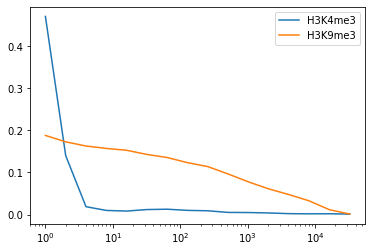

In [140]:
lags = 2**np.arange(16)
autocorrs_H3K4me3 = []
autocorrs_H3K9me3 = []
for lag in lags:
    autocorrs_H3K4me3.append(full_genome_H3K4me3['-log(qvalue_complete)'].astype(float).autocorr(lag=lag))
    autocorrs_H3K9me3.append(full_genome_H3K9me3['-log(qvalue_complete)'].astype(float).autocorr(lag=lag))
plt.plot(lags, autocorrs_H3K4me3, label='H3K4me3')
plt.plot(lags, autocorrs_H3K9me3, label='H3K9me3')
plt.xscale('log')
plt.legend()
plt.show()
plt.close()

Load npz format

In [250]:
data = 'Judith-H3K9me3'
genome = 'GRCh38'
chr_id = 1
with np.load(Path(data_dir, data, 'results', 'alignments', genome, f'{data}_{genome}_IP_coord_all_chr.npz')) as f:
    ip_coord_chr = f[hg38_chr_ids[chr_id]]
with np.load(Path(data_dir, data, 'results', 'alignments', genome, f'{data}_{genome}_Control_coord_all_chr.npz')) as f:
    ctrl_coord_chr = f[hg38_chr_ids[chr_id]]
# data2 = 'Judith-H3K4me3'
# with np.load(Path(data_dir, data2, 'results', f'{data2}_IP_coord_all_chr.npz')) as f:
#     ip2_coord_chr = f[hg38_chr_names[chr_id]]
# with np.load(Path(data_dir, data2, 'results', f'{data2}_Control_coord_all_chr.npz')) as f:
#     ctrl2_coord_chr = f[hg38_chr_names[chr_id]]
# data3 = 'Judith-H3K27me3'
# with np.load(Path(data_dir, data3, 'results', f'{data3}_Control_coord_all_chr.npz')) as f:
#     ctrl3_coord_chr = f[hg38_chr_names[chr_id]]
#     # for key in f.keys():
#     #     print(key)

Plot lengths

In [251]:
ip_lengths_chr = np.diff(ip_coord_chr, axis=1).ravel()
ctrl_lengths_chr = np.diff(ctrl_coord_chr, axis=1).ravel()
# ip2_lengths_chr = np.diff(ip2_coord_chr, axis=1).ravel()
# ctrl2_lengths_chr = np.diff(ctrl2_coord_chr, axis=1).ravel()
# ctrl3_lengths_chr = np.diff(ctrl3_coord_chr, axis=1).ravel()

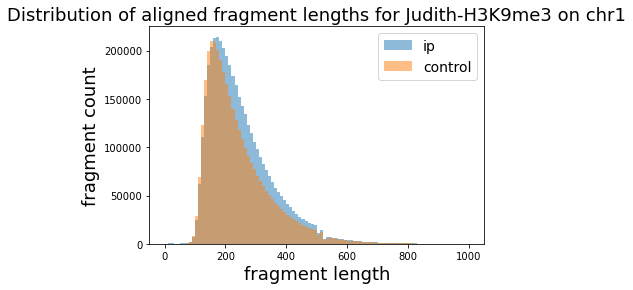

In [253]:
plt.hist(ip_lengths_chr, bins=100, range=(0, 1000), label='ip', alpha=0.5)
plt.hist(ctrl_lengths_chr, bins=100, range=(0, 1000), label='control', alpha=0.5)
# plt.hist(ip2_lengths_chr, bins=100, range=(0, 1000), label='ip2', alpha=0.5)
# plt.hist(ctrl2_lengths_chr, bins=100, range=(0, 1000), label='control2', alpha=0.5)
# plt.hist(ctrl3_lengths_chr, bins=100, range=(0, 1000), label='control3', alpha=0.5)
plt.legend(fontsize=14)
plt.title(f'Distribution of aligned fragment lengths for {data} on chr{chr_id}', fontsize=18)
plt.xlabel('fragment length', fontsize=18)
plt.ylabel('fragment count', fontsize=18)
fig_name = 
plt.savefig(f'{data_dir}/{data}/results/{data}_fragment_length_distribution_chr{chr_id}.png', bbox_inches='tight')
plt.show()
plt.close()

Filter out long fragments

In [254]:
# filter out long fragments
threshold = 1000
print(np.sum(ip_lengths_chr >= threshold), f'fragments longer than {threshold}bp in IP')
ip_coord_chr = ip_coord_chr[ip_lengths_chr <= threshold, :]
print(np.sum(ctrl_lengths_chr >= threshold), f'fragments longer than {threshold}bp in Control')
ctrl_coord_chr = ctrl_coord_chr[ctrl_lengths_chr <= threshold, :]

# print(np.sum(ip2_lengths_chr >= threshold), f'fragments longer than {threshold}bp in IP2')
# ip2_coord_chr = ip2_coord_chr[ip2_lengths_chr <= threshold, :]
# print(np.sum(ctrl2_lengths_chr >= threshold), f'fragments longer than {threshold}bp in Control2')
# ctrl2_coord_chr = ctrl2_coord_chr[ctrl2_lengths_chr <= threshold, :]

# print(np.sum(ctrl3_lengths_chr >= threshold), f'fragments longer than {threshold}bp in Control3')
# ctrl3_coord_chr = ctrl3_coord_chr[ctrl3_lengths_chr <= threshold, :]

485 fragments longer than 1000bp in IP
572 fragments longer than 1000bp in Control


#### Binned middle alignment

In [255]:
importlib.reload(utils)
bins = 1000
ip_binned_signal_chr = utils.binned_alignment_signal_from_coord(ip_coord_chr, bins=bins, length=GRCh38_lengths[f'chr{chr_id}'])
ctrl_binned_signal_chr = utils.binned_alignment_signal_from_coord(ctrl_coord_chr, bins=bins, length=GRCh38_lengths[f'chr{chr_id}'])
print(len(ip_binned_signal_chr), len(ctrl_binned_signal_chr))

# ip2_binned_signal_chr = utils.binned_alignment_signal_from_coord(ip2_coord_chr, bins=bins)
# ctrl2_binned_signal_chr = utils.binned_alignment_signal_from_coord(ctrl2_coord_chr, bins=bins)
# print(len(ip2_binned_signal_chr), len(ctrl2_binned_signal_chr))

# ctrl3_binned_signal_chr = utils.binned_alignment_signal_from_coord(ctrl3_coord_chr, bins=bins)
# print(len(ctrl3_binned_signal_chr))

248957 248957


In [294]:
log_ratio_chr = np.log10(ip_binned_signal_chr / ctrl_binned_signal_chr)
KL_chr = ip_binned_signal_chr * np.log10(ip_binned_signal_chr / ctrl_binned_signal_chr)

p_binom = len(ip_coord_chr) / (len(ip_coord_chr) + len(ctrl_coord_chr))
n_binom = ip_binned_signal_chr + ctrl_binned_signal_chr
p_vals2 = 1 - scipy.stats.binom.cdf(ip_binned_signal_chr - 1, n_binom, p_binom)

/tmp/ipykernel_240455/3108555742.py:1: RuntimeWarning: divide by zero encountered in true_divide
  log_ratio_chr = np.log10(ip_binned_signal_chr / ctrl_binned_signal_chr)
/tmp/ipykernel_240455/3108555742.py:1: RuntimeWarning: invalid value encountered in true_divide
  log_ratio_chr = np.log10(ip_binned_signal_chr / ctrl_binned_signal_chr)
/tmp/ipykernel_240455/3108555742.py:1: RuntimeWarning: divide by zero encountered in log10
  log_ratio_chr = np.log10(ip_binned_signal_chr / ctrl_binned_signal_chr)
/tmp/ipykernel_240455/3108555742.py:2: RuntimeWarning: divide by zero encountered in true_divide
  KL_chr = ip_binned_signal_chr * np.log10(ip_binned_signal_chr / ctrl_binned_signal_chr)
/tmp/ipykernel_240455/3108555742.py:2: RuntimeWarning: invalid value encountered in true_divide
  KL_chr = ip_binned_signal_chr * np.log10(ip_binned_signal_chr / ctrl_binned_signal_chr)
/tmp/ipykernel_240455/3108555742.py:2: RuntimeWarning: divide by zero encountered in log10
  KL_chr = ip_binned_signal_ch

In [295]:
from statsmodels.stats import multitest
reject, q_vals, alphaS, alphaB = multitest.multipletests(p_vals, method='fdr_bh')
print(np.sum(reject), "/", len(reject), "rejected")
print(alphaS, alphaB)

202 / 248957 rejected
2.06032724991978e-07 2.0083789570086402e-07


In [246]:
df = pd.DataFrame({'pos': np.arange(0, len(ip_binned_signal_chr)*bins, bins),
                   'ip_binned_signal': ip_binned_signal_chr,
                   'ctrl_binned_signal': ctrl_binned_signal_chr,
                   'log_ratio': log_ratio_chr,
                   'KL': KL_chr,
                   'binom_p_value': p_vals,
                   'binom_q_value': q_vals})
df.to_csv(f'{data_dir}/{data}/results/alignments/{genome}/{data}_{genome}_chr{chr_id}_binned_{bins}.csv')

Plot of raw signal

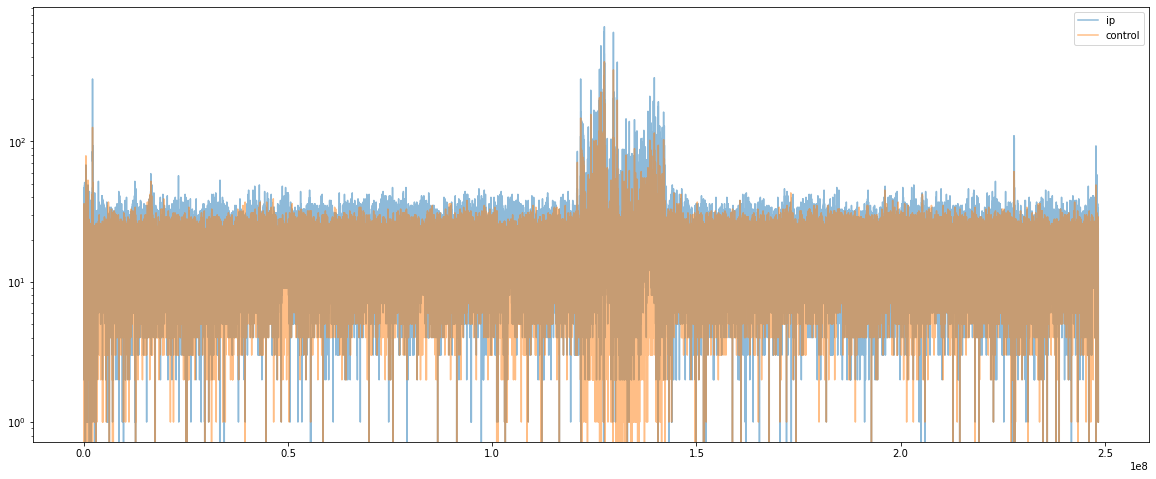

In [206]:
start = 0  # 30_000_000
end = len(ip_binned_signal_chr)*bins
bin_start = (start // bins) * bins + bins // 2
bin_end = (end // bins) * bins + bins // 2
plt.figure(figsize=(20, 8))
plt.plot(np.arange(bin_start, bin_end, bins), ip_binned_signal_chr[start//bins:end//bins], label='ip', alpha=0.5)
plt.plot(np.arange(bin_start, bin_end, bins), ctrl_binned_signal_chr[start//bins:end//bins], label='control', alpha=0.5)
# plt.plot(np.arange(bin_start, bin_end, bins), ip2_binned_signal_chr[start//bins:end//bins], label='ip2', alpha=0.5)
# plt.plot(np.arange(bin_start, bin_end, bins), ctrl2_binned_signal_chr[start//bins:end//bins], label='control2', alpha=0.5)
# plt.plot(np.arange(bin_start, bin_end, bins), ctrl3_binned_signal_chr[start//bins:end//bins], label='control3', alpha=0.5)
plt.yscale('log')
plt.legend()
plt.show()
plt.close()

In [ ]:
# df = pd.DataFrame({'pos': np.arange(0, len(ip_binned_signal_chr)*bins, bins),
#                    'H3K9me3': ip_binned_signal_chr,
#                    'H3K4me3': ip2_binned_signal_chr,
#                    'ctrl_H3K9me3': ctrl_binned_signal_chr,
#                    'ctrl_H3K4me3': ctrl2_binned_signal_chr,
#                    'ctrl_H3K27me3': ctrl3_binned_signal_chr
#                    })
# df.to_csv(f'{data_dir}/{data3}/results/All_chr{chr_id}_binned_{bins}.csv')

In [4]:
data3 = "Judith-H3K27me3"
bins = 1000
chr_id = 1
df = pd.read_csv(f'{data_dir}/{data3}/results/All_chr{chr_id}_binned_{bins}.csv', index_col=0)

<AxesSubplot:>

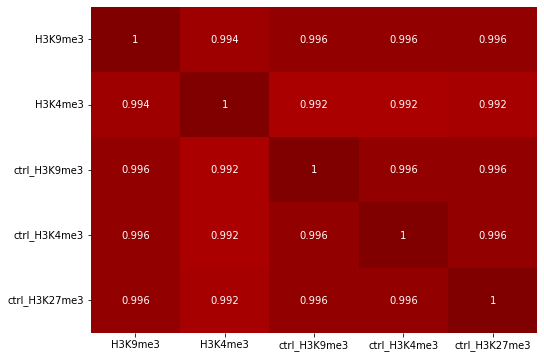

In [ ]:
corrs = np.corrcoef(df.iloc[:,1:], rowvar=False)
plt.figure(figsize=(8, 6))
sns.heatmap(corrs, vmin=0.9, vmax=1, annot=True, fmt='.3g',
            cmap=plt.cm.get_cmap('seismic'), cbar=False,
            xticklabels=df.columns[1:], yticklabels=df.columns[1:])

Processed signals

In [ ]:
def KL(x, y):
    return x * np.log10(x / y)

df['KL_H3K4me3_ctrl4'] = KL(df['H3K4me3'], df['ctrl_H3K4me3'])
df['KL_H3K4me3_ctrl9'] = KL(df['H3K4me3'], df['ctrl_H3K9me3'])
df['KL_H3K4me3_ctrl27'] = KL(df['H3K4me3'], df['ctrl_H3K27me3'])
df['KL_H3K9me3_ctrl4'] = KL(df['H3K9me3'], df['ctrl_H3K4me3'])
df['KL_H3K9me3_ctrl9'] = KL(df['H3K9me3'], df['ctrl_H3K9me3'])
df['KL_H3K9me3_ctrl27'] = KL(df['H3K9me3'], df['ctrl_H3K27me3'])


/home/alex/anaconda3/envs/tf2.5/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


(230014, 12)
(230220, 12)


<AxesSubplot:>

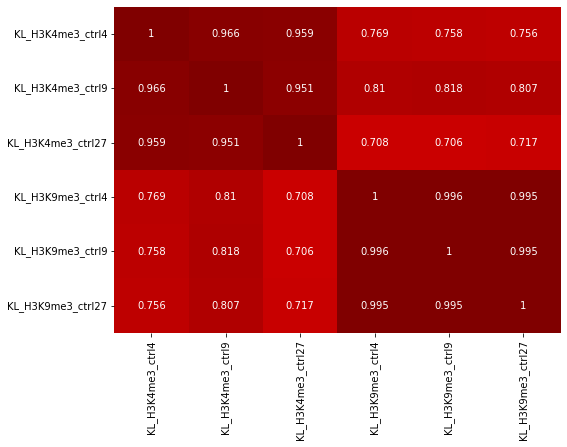

In [ ]:
df2 = df.where(np.isfinite(df)).dropna()
print(df2.shape)
print(df.shape)
corrs_processed = np.corrcoef(df2.iloc[:,6:], rowvar=False)
plt.figure(figsize=(8, 6))
sns.heatmap(corrs_processed, vmin=-1, vmax=1, annot=True, fmt='.3g',
            cmap=plt.cm.get_cmap('seismic'), cbar=False,
            xticklabels=df2.columns[6:], yticklabels=df2.columns[6:])

/tmp/ipykernel_240455/2711071431.py:5: RuntimeWarning: divide by zero encountered in log10
  values_list = [log_ratio_chr, KL_chr, -np.log10(p_vals)]


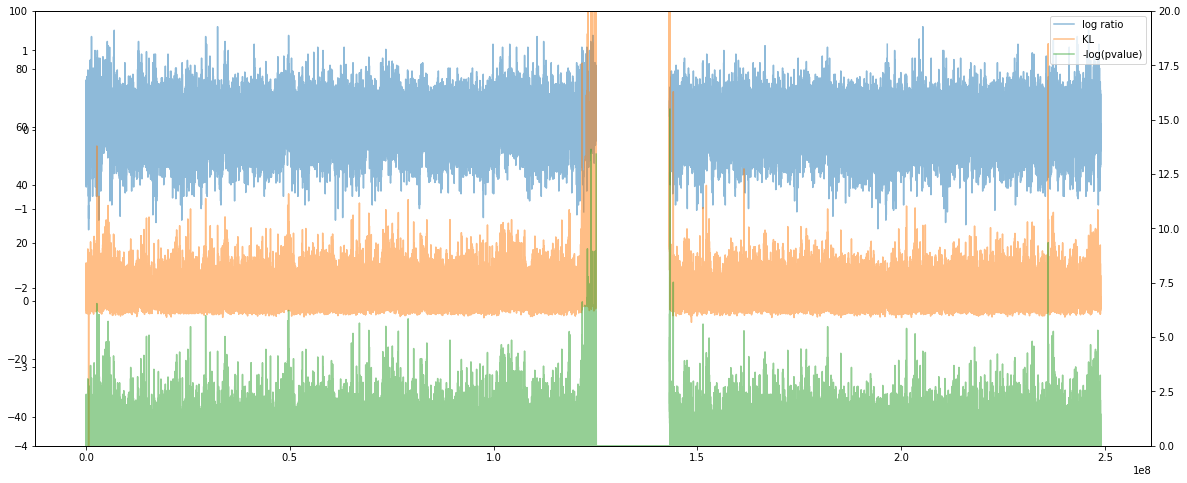

In [290]:
importlib.reload(plot_utils)
start = 0 # 30_000_000
end = len(ip_binned_signal_chr)*bins
plt.figure(figsize=(20, 8))
values_list = [log_ratio_chr, KL_chr, -np.log10(p_vals)]
label_list = ['log ratio', 'KL', '-log(pvalue)']
axes = plot_utils.compare_binned_plots(values_list, label_list, start, end, bins, alpha=0.5)
axes[0].set_ylim(bottom=-4, top=1.5)
axes[1].set_ylim(bottom=-50, top=100)
axes[2].set_ylim(bottom=0, top=20)
plt.show()
plt.close()

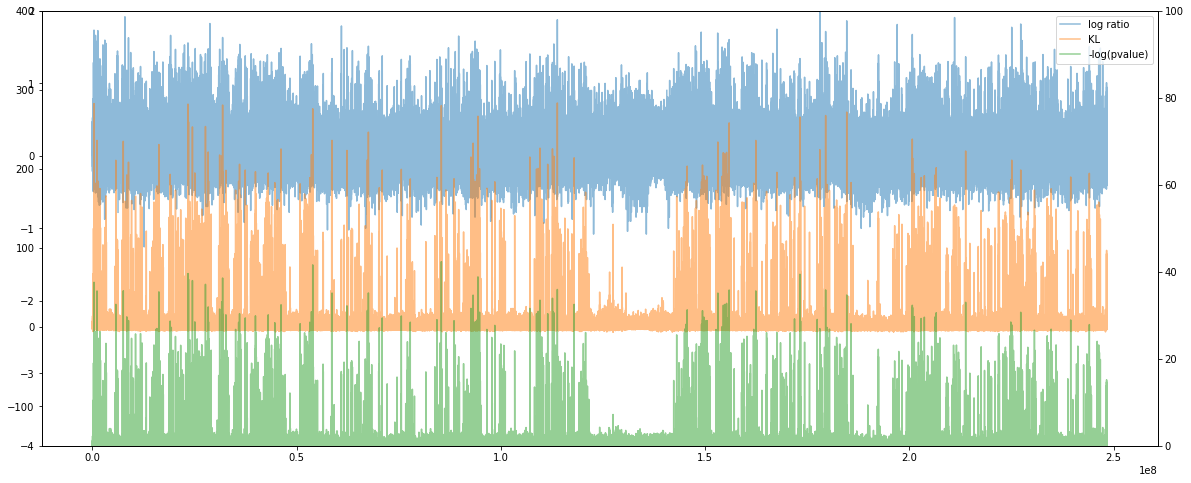

In [155]:
importlib.reload(plot_utils)
start = 0 # 30_000_000
end = len(ip_binned_signal_chr)*bins
plt.figure(figsize=(20, 8))
values_list = [log_ratio_chr, KL_chr, -np.log10(p_vals)]
label_list = ['log ratio', 'KL', '-log(pvalue)']
axes = plot_utils.compare_binned_plots(values_list, label_list, start, end, bins, alpha=0.5)
axes[0].set_ylim(bottom=-4, top=2)
axes[1].set_ylim(bottom=-150, top=400)
axes[2].set_ylim(bottom=0, top=100)
plt.show()
plt.close()

/home/alex/anaconda3/envs/tf2.5/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


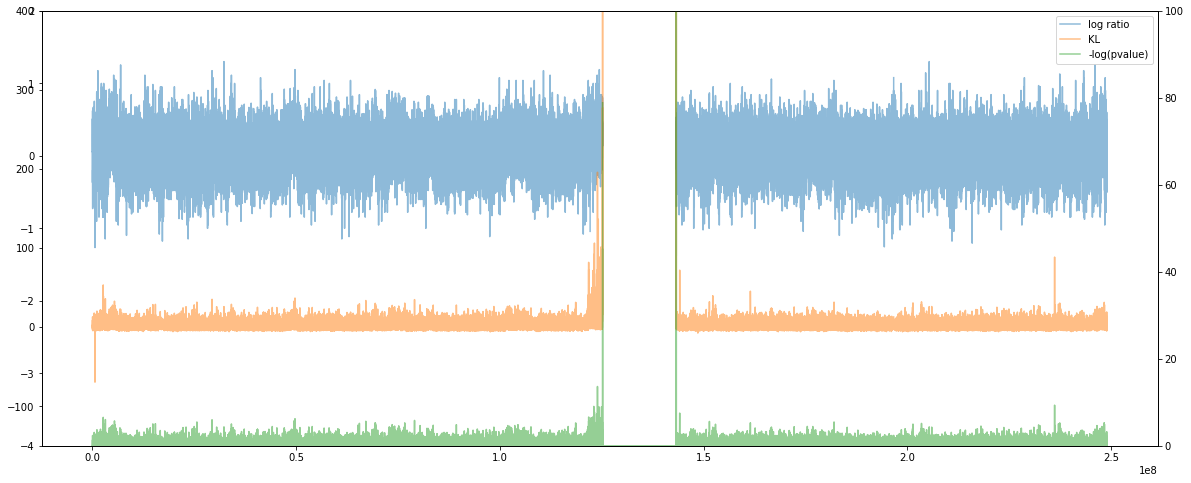

In [182]:
data = 'Judith-H3K9me3'
df = pd.read_csv(f'{data_dir}/{data}/results/alignments/GRCh38/{data}_chr{chr_id}_binned_{bins}.csv')
ip_binned_signal_chr = df['ip_binned_signal']
log_ratio_chr = df['log_ratio']
KL_chr = df['KL']
p_vals = df['binom_p_value']
start = 0 # 30_000_000
end = len(ip_binned_signal_chr)*bins
plt.figure(figsize=(20, 8))
values_list = [log_ratio_chr, KL_chr, -np.log10(p_vals)]
label_list = ['log ratio', 'KL', '-log(pvalue)']
axes = plot_utils.compare_binned_plots(values_list, label_list, start, end, bins, alpha=0.5)
axes[0].set_ylim(bottom=-4, top=2)
axes[1].set_ylim(bottom=-150, top=400)
axes[2].set_ylim(bottom=0, top=100)
plt.show()
plt.close()

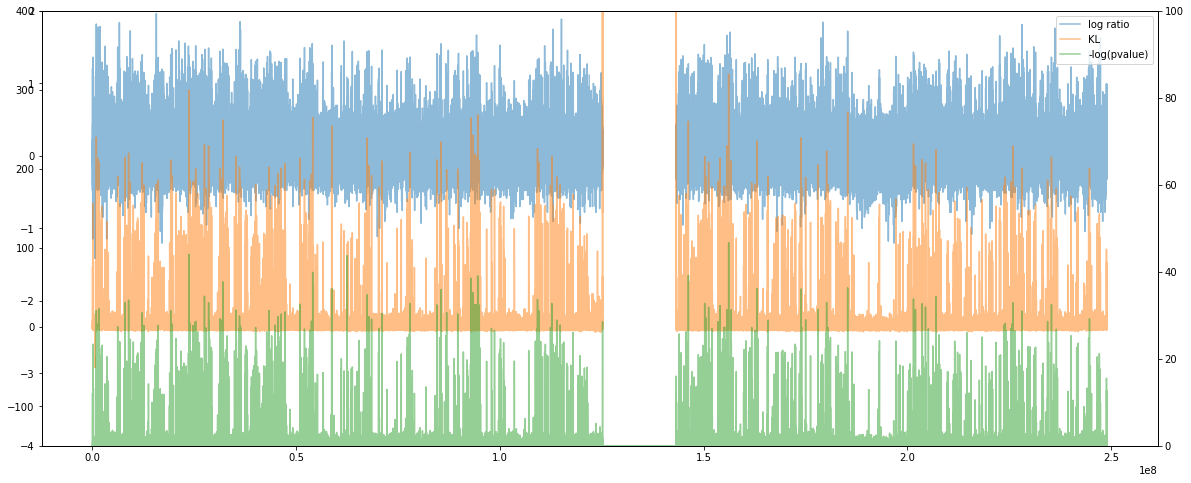

In [183]:
data = 'Judith-H3K4me3'
df = pd.read_csv(f'{data_dir}/{data}/results/alignments/GRCh38/{data}_chr{chr_id}_binned_{bins}.csv')
ip_binned_signal_chr = df['ip_binned_signal']
log_ratio_chr = df['log_ratio']
KL_chr = df['KL']
p_vals = df['binom_p_value']
start = 0 # 30_000_000
end = len(ip_binned_signal_chr)*bins
plt.figure(figsize=(20, 8))
values_list = [log_ratio_chr, KL_chr, -np.log10(p_vals)]
label_list = ['log ratio', 'KL', '-log(pvalue)']
axes = plot_utils.compare_binned_plots(values_list, label_list, start, end, bins, alpha=0.5)
axes[0].set_ylim(bottom=-4, top=2)
axes[1].set_ylim(bottom=-150, top=400)
axes[2].set_ylim(bottom=0, top=100)
plt.show()
plt.close()

Correlation between processed signals

In [156]:
valid_bins = np.logical_and(np.isfinite(KL_chr), np.isfinite(-np.log10(p_vals)))
print(pearsonr(KL_chr[valid_bins], -np.log10(p_vals)[valid_bins]))
print(pearsonr(KL_chr[valid_bins], log_ratio_chr[valid_bins]))
print(pearsonr(-np.log10(p_vals)[valid_bins], log_ratio_chr[valid_bins]))

(0.9912833207835683, 0.0)
(0.6653103968940027, 0.0)
(0.6056913679136753, 0.0)


Plot of processed signals

/tmp/ipykernel_126826/2145195069.py:11: RuntimeWarning: divide by zero encountered in log10
  ax3.plot(np.arange(bin_start, bin_end, bins), -np.log10(p_vals)[start//bins:end//bins], label='-log(pvalue)', alpha=0.5, color=colors[2])


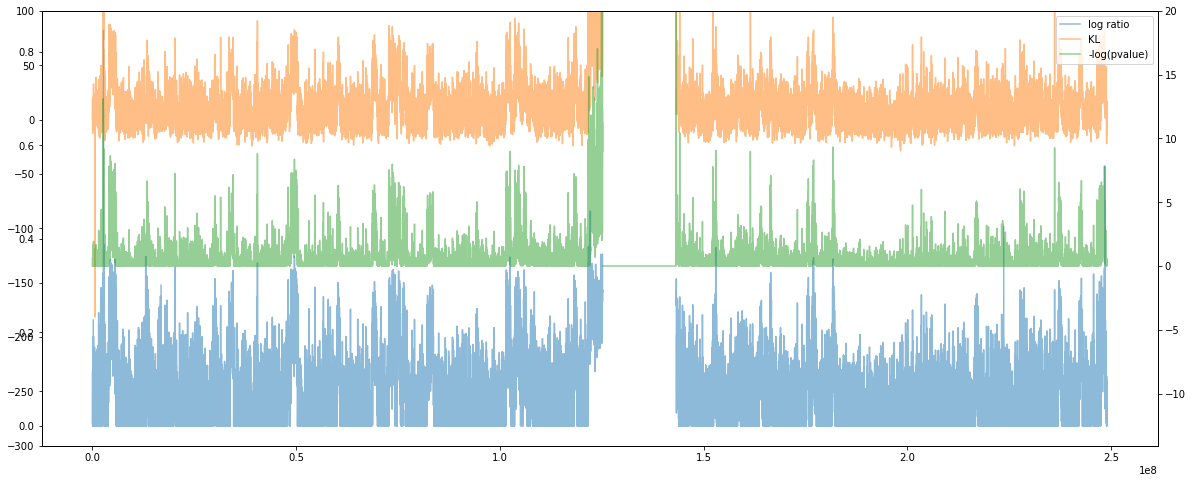

In [ ]:
start = 0 # 30_000_000
end = len(ip_binned_signal_chr)*bins
bin_start = (start // bins) * bins + bins // 2
bin_end = (end // bins) * bins + bins // 2
plt.figure(figsize=(20, 8))
ax1 = plt.subplot()
ax1.plot(np.arange(bin_start, bin_end, bins), np.maximum(log_ratio_chr[start//bins:end//bins], 0), label='log ratio', alpha=0.5)
ax2 = ax1.twinx()
ax2.plot(np.arange(bin_start, bin_end, bins), KL_chr[start//bins:end//bins], label='KL', alpha=0.5, color=colors[1])
ax3 = ax2.twinx()
ax3.plot(np.arange(bin_start, bin_end, bins), -np.log10(p_vals)[start//bins:end//bins], label='-log(pvalue)', alpha=0.5, color=colors[2])
# ax1.set_ylim(bottom=-1.5)
ax2.set_ylim(bottom=-300, top=100)
ax3.set_ylim(top=20)
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles3, labels3 = ax3.get_legend_handles_labels()
plt.legend(handles1 + handles2 + handles3, labels1 + labels2 + labels3)
plt.show()
plt.close()

/tmp/ipykernel_270277/2435503918.py:5: RuntimeWarning: divide by zero encountered in log
  N = np.log(ip_binned_signal_chr)
/tmp/ipykernel_270277/2435503918.py:8: RuntimeWarning: invalid value encountered in multiply
  plt.scatter(KL_chr[start//bins:end//bins], (-np.log10(p_vals)*N)[start//bins:end//bins], c=N, cmap='YlOrRd', label='positions', alpha=0.5)


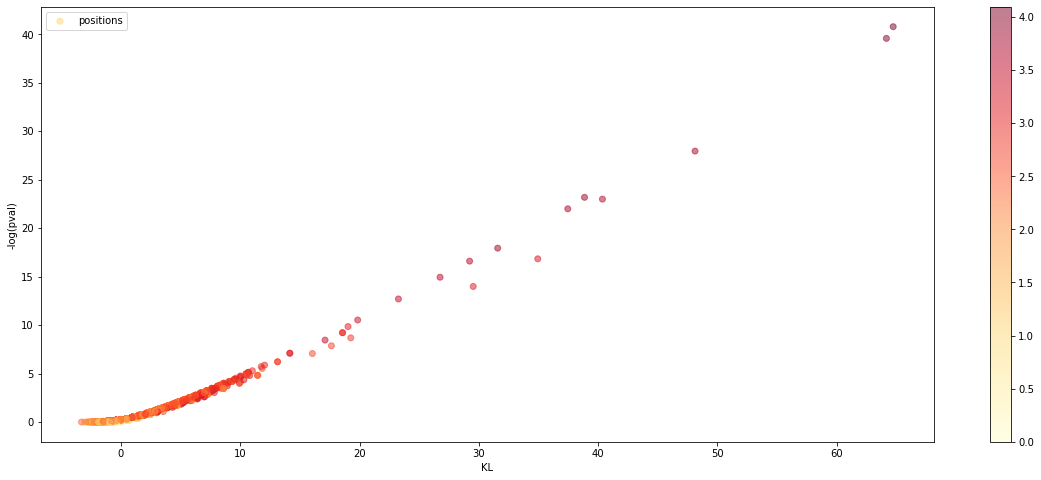

In [73]:
start = 0 # 30_000_000
end = len(ip_binned_signal_chr)*bins
bin_start = (start // bins) * bins + bins // 2
bin_end = (end // bins) * bins + bins // 2
N = np.log(ip_binned_signal_chr)
plt.figure(figsize=(20, 8))
# ax1 = plt.subplot()
plt.scatter(KL_chr[start//bins:end//bins], (-np.log10(p_vals)*N)[start//bins:end//bins], c=N, cmap='YlOrRd', label='positions', alpha=0.5)
# plt.xlim(left=0, right=200)
# plt.ylim(bottom=0, top=15)
plt.xlabel('KL')
plt.ylabel('-log(pval)')
plt.legend()
plt.colorbar()
plt.show()
plt.close()

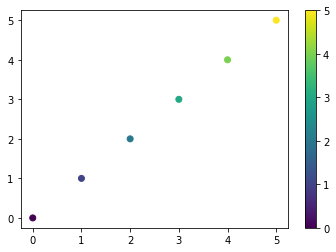

In [188]:
x = np.arange(6)
plt.scatter(x,x,c=x)
plt.colorbar()

Save to csv

In [213]:
df = pd.DataFrame({'pos': np.arange(0, len(ip_binned_signal_chr)*bins, bins),
                   'ip_binned_signal': ip_binned_signal_chr,
                   'ctrl_binned_signal': ctrl_binned_signal_chr,
                   'log_ratio': log_ratio_chr,
                   'KL': KL_chr,
                   'binom_p_value': p_vals})
df.to_csv(f'{data_dir}/{data}/results/alignments/{genome}/{data}_{genome}_chr{chr_id}_binned_{bins}.csv')

#### Exact alignment

In [ ]:
ip_signal_chr = utils.exact_alignment_signal_from_coord(ip_coord_chr)
ctrl_signal_chr = utils.exact_alignment_signal_from_coord(ctrl_coord_chr)
print(len(ip_signal_chr), len(ctrl_signal_chr))
ip_signal_chr, ctrl_signal_chr = utils.adjust_length(ip_signal_chr, ctrl_signal_chr)
print(len(ip_signal_chr), len(ctrl_signal_chr))

248946395 248946413
248946413 248946413


In [ ]:
ip_postbinned_signal_chr = convolve(ip_signal_chr, np.ones(bins) / bins, mode='same')
ctrl_postbinned_signal_chr = convolve(ctrl_signal_chr, np.ones(bins) / bins, mode='same')

In [ ]:
postbinned_log_ratio_chr = np.log10(ip_postbinned_signal_chr / ctrl_postbinned_signal_chr)
postbinned_KL_chr = ip_postbinned_signal_chr * np.log10(ip_postbinned_signal_chr / ctrl_postbinned_signal_chr)

# p_binom = len(ip_coord_chr) / (len(ip_coord_chr) + len(ctrl_coord_chr))
# p_vals = np.zeros(len(ip_postbinned_signal_chr))
# for i in range(len(ip_postbinned_signal_chr)):
#     n_binom = ip_postbinned_signal_chr[i] + ctrl_postbinned_signal_chr[i]
#     k_binom = ip_postbinned_signal_chr[i]
#     if n_binom >= 1:
#         res = scipy.stats.binomtest(k_binom, n_binom, p=p_binom, alternative='greater')
#         p_vals[i] = res.pvalue
#     else:
#         p_vals[i] = 1

/tmp/ipykernel_122611/899252405.py:1: RuntimeWarning: divide by zero encountered in true_divide
  postbinned_log_ratio_chr = np.log10(ip_postbinned_signal_chr / ctrl_postbinned_signal_chr)
/tmp/ipykernel_122611/899252405.py:1: RuntimeWarning: invalid value encountered in true_divide
  postbinned_log_ratio_chr = np.log10(ip_postbinned_signal_chr / ctrl_postbinned_signal_chr)
/tmp/ipykernel_122611/899252405.py:1: RuntimeWarning: divide by zero encountered in log10
  postbinned_log_ratio_chr = np.log10(ip_postbinned_signal_chr / ctrl_postbinned_signal_chr)
/tmp/ipykernel_122611/899252405.py:1: RuntimeWarning: invalid value encountered in log10
  postbinned_log_ratio_chr = np.log10(ip_postbinned_signal_chr / ctrl_postbinned_signal_chr)
/tmp/ipykernel_122611/899252405.py:2: RuntimeWarning: divide by zero encountered in true_divide
  postbinned_KL_chr = ip_postbinned_signal_chr * np.log10(ip_postbinned_signal_chr / ctrl_postbinned_signal_chr)
/tmp/ipykernel_122611/899252405.py:2: RuntimeWarn

In [ ]:
start = 0 # 122_000_000
end = len(ip_signal_chr)  # 40_000_000
plt.figure(figsize=(20, 8))
ax1 = plt.subplot()
ax1.plot(np.arange(start, end), ip_postbinned_signal_chr[start:end], label='ip', alpha=0.5)
repeats = utils.find_peaks_in_window(all_chr_repeats, start, end)
print(repeats.shape)
rep_height = 1
for id, (rep_start, rep_end, *_) in enumerate(repeats):
    if id == 0:
        ax1.plot([rep_start, rep_end], [rep_height, rep_height], marker = '.', color='red', label='repeats')
    else:
        ax1.plot([rep_start, rep_end], [rep_height, rep_height], marker = '.', color='red')
# plt.plot(np.arange(start, end), ctrl_signal_chr[start:end], label='control', alpha=0.5)
ax1.set_yscale('log')
# handles1, labels1 = ax1.get_legend_handles_labels()
plt.legend(loc="upper right")
plt.show()
plt.close()

(444217, 2)


: 

: 

In [100]:
ip_binned_signal_chr_old = pd.read_csv(f'{data_dir}/{data}/results/alignments/{genome}/{data}_chr{chr_id}_binned_{bins}.csv')

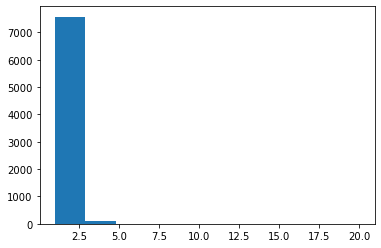

(array([7.572e+03, 8.800e+01, 9.000e+00, 4.000e+00, 2.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 2.000e+00, 2.000e+00]),
 array([ 1. ,  2.9,  4.8,  6.7,  8.6, 10.5, 12.4, 14.3, 16.2, 18.1, 20. ]),
 <BarContainer object of 10 artists>)

In [102]:
diffs = np.array(np.abs(ip_binned_signal_chr - ip_binned_signal_chr_old['ip_binned_signal']))
nonzeros, = np.nonzero(diffs)
res = plt.hist(diffs[nonzeros])
plt.show()
plt.close()
diffs[nonzeros]
res

In [ ]:
import timeit
n = 10_000_000
m = 100_000_000
coord = np.random.randint(0, m, size=2*n, dtype=int).reshape(-1, 2)
# print(coord)

In [ ]:
%%timeit
signal = utils.exact_alignment_signal_from_coord(coord)

1.33 s ± 47.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit
binned_signal = utils.binned_alignment_signal_from_coord(coord, bins=1000)

794 ms ± 12.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit
binned_signal = utils.binned_alignment_signal_from_coord(coord, bins=1)

1.23 s ± 90.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
